# Pronto Cycleshare

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

## Downloading Pronto's Data

- Data release page: http://www.prontocycleshare.com/datachallenge

In [2]:
import os
if not os.path.exists('open_data_year_one.zip'):
    !curl -O https://s3.amazonaws.com/pronto-data/open_data_year_one.zip
    !unzip open_data_year_one.zip

In [3]:
trips = pd.read_csv('2015_trip_data.csv',
                    parse_dates=['starttime', 'stoptime'],
                    infer_datetime_format=True)
trips.columns

Index(['trip_id', 'starttime', 'stoptime', 'bikeid', 'tripduration',
       'from_station_name', 'to_station_name', 'from_station_id',
       'to_station_id', 'usertype', 'gender', 'birthyear'],
      dtype='object')

## Exploring Trips over Time

### Trips Over the Year

In [4]:
# Find the start date
ind = pd.DatetimeIndex(trips.starttime)
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour

In [5]:
# Count trips by date
by_date = trips.pivot_table('trip_id', aggfunc='count',
                            index='date',
                            columns='usertype', )

# Count trips by weekday
weekly = by_date.pivot_table(['Annual Member', 'Short-Term Pass Holder'],
                             index=by_date.index.weekofyear,
                             columns=by_date.index.dayofweek)

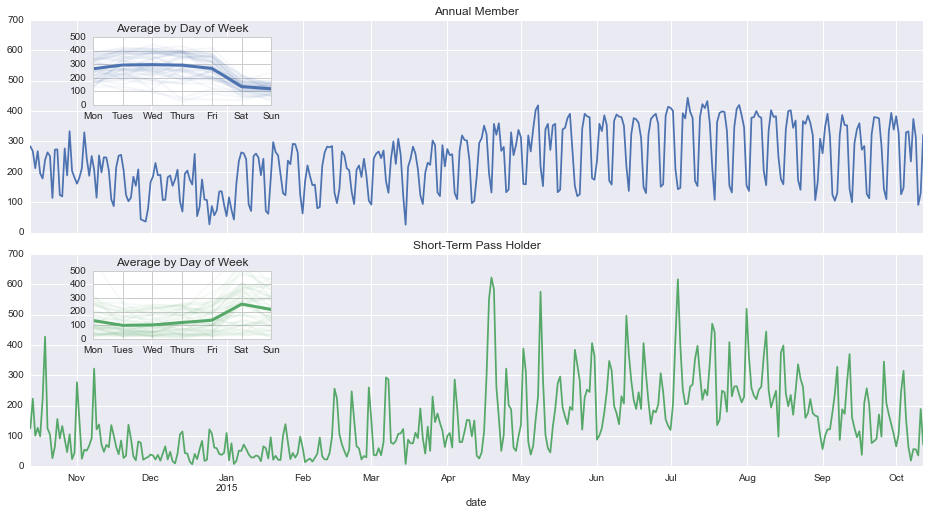

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.1)

def add_inset(ax, rect, *args, **kwargs):
    box = ax.get_position()
    inax_position = ax.transAxes.transform(rect[0:2])
    infig_position = ax.figure.transFigure.inverted().transform(inax_position)
    new_rect = list(infig_position) + [box.width * rect[2], box.height * rect[3]]
    return fig.add_axes(new_rect, *args, **kwargs)

color_cycle = plt.rcParams['axes.color_cycle']
for i, col in enumerate(['Annual Member', 'Short-Term Pass Holder']):
    by_date[col].plot(ax=ax[i], title=col, color=color_cycle[i])

with sns.axes_style('whitegrid'):
    inset = [add_inset(ax[0], [0.07, 0.6, 0.2, 0.32]),
             add_inset(ax[1], [0.07, 0.6, 0.2, 0.32])]

for i, col in enumerate(['Annual Member', 'Short-Term Pass Holder']):
    inset[i].plot(range(7), weekly[col].values.T, color=color_cycle[i], lw=2, alpha=0.05);
    inset[i].plot(range(7), weekly[col].mean(0), color=color_cycle[i], lw=3)
    inset[i].set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
    inset[i].yaxis.set_major_locator(plt.MaxNLocator(5))
    inset[i].set_ylim(0, 500)
    inset[i].set_title('Average by Day of Week')
    
fig.savefig('basic_trend.png')

### Trips Over a Day

In [7]:
ind = pd.DatetimeIndex(trips.date)
ind.dayofweek

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

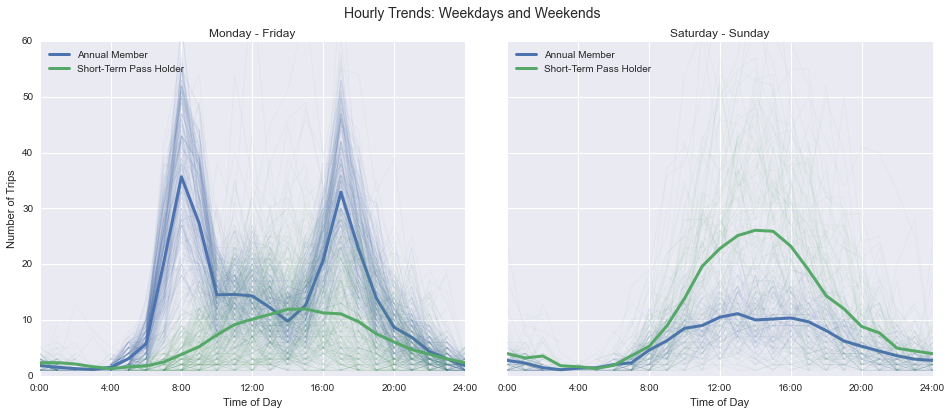

In [8]:
trips['weekend'] = (ind.dayofweek > 4)
hourly = trips.pivot_table('trip_id', aggfunc='count',
                           index=['date'], columns=['usertype', 'weekend', 'hour'])
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)
fmt = plt.FuncFormatter(lambda x, *args: '{0}:00'.format(int(x)))

for weekend in (False, True):
    axi = ax[int(weekend)]
    for i, col in enumerate(['Annual Member', 'Short-Term Pass Holder']):
        vals = hourly[col][weekend].values
        vals = np.hstack([vals, vals[:, :1]])
        axi.plot(range(25), vals.T,
                 color=color_cycle[i], lw=1, alpha=0.05)
        axi.plot(range(25), np.nanmean(vals, 0),
                 color=color_cycle[i], lw=3, label=col)
    axi.xaxis.set_major_locator(plt.MultipleLocator(4))
    axi.xaxis.set_major_formatter(fmt)
    axi.set_ylim(0, 60)
    axi.set_title('Saturday - Sunday' if weekend else 'Monday - Friday')
    axi.legend(loc='upper left')
    axi.set_xlabel('Time of Day')
ax[0].set_ylabel('Number of Trips')
fig.suptitle('Hourly Trends: Weekdays and Weekends', size=14);

## Trip Durations

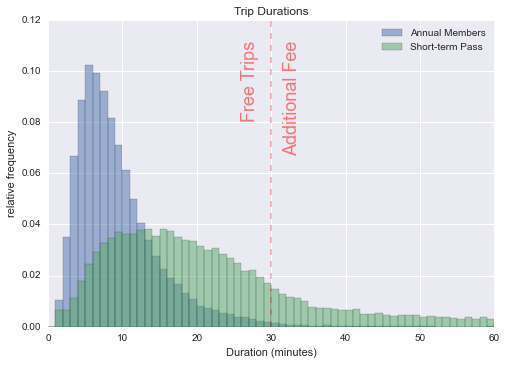

In [9]:
trips['minutes'] = trips.tripduration / 60
trips.groupby('usertype')['minutes'].hist(bins=np.arange(61), alpha=0.5, normed=True);
plt.xlabel('Duration (minutes)')
plt.ylabel('relative frequency')
plt.title('Trip Durations')
plt.text(34, 0.09, "Free Trips\n\nAdditional Fee", ha='right',
         size=18, rotation=90, alpha=0.5, color='red')
plt.legend(['Annual Members', 'Short-term Pass'])

plt.axvline(30, linestyle='--', color='red', alpha=0.3);

## Trip Distances & Rider Speed

In [10]:
stations = pd.read_csv('2015_station_data.csv')
pronto_shop = dict(id=54, name="Pronto shop",
                   terminal="Pronto shop",
                   lat=47.6173156, long=-122.3414776,
                   dockcount=100, online='10/13/2014')
stations = stations.append(pronto_shop, ignore_index=True)

In [11]:
# Here we query the Google Maps API for distances between trips

from time import sleep

def query_distances(stations=stations):
    """Query the Google API for bicycling distances"""
    latlon_list = ['{0},{1}'.format(lat, long)
                   for (lat, long) in zip(stations.lat, stations.long)]

    def create_url(i):
        URL = ('https://maps.googleapis.com/maps/api/distancematrix/json?'
               'origins={origins}&destinations={destinations}&mode=bicycling')
        return URL.format(origins=latlon_list[i],
                          destinations='|'.join(latlon_list[i + 1:]))

    for i in range(len(latlon_list) - 1):
        url = create_url(i)
        filename = "distances_{0}.json".format(stations.terminal.iloc[i])
        print(i, filename)
        !curl "{url}" -o {filename}
        sleep(11) # only one query per 10 seconds!


def build_distance_matrix(stations=stations):
    """Build a matrix from the Google API results"""
    dist = np.zeros((len(stations), len(stations)), dtype=float)
    for i, term in enumerate(stations.terminal[:-1]):
        filename = 'queried_distances/distances_{0}.json'.format(term)
        row = json.load(open(filename))
        dist[i, i + 1:] = [el['distance']['value'] for el in row['rows'][0]['elements']]
    dist += dist.T
    distances = pd.DataFrame(dist, index=stations.terminal,
                             columns=stations.terminal)
    distances.to_csv('station_distances.csv')
    return distances

# only call this the first time
import os
if not os.path.exists('station_distances.csv'):
    # Note: you can call this function at most ~twice per day!
    query_distances()

    # Move all the queried files into a directory
    # so we don't accidentally overwrite them
    if not os.path.exists('queried_distances'):
        os.makedirs('queried_distances')
    !mv distances_*.json queried_distances

    # Build distance matrix and save to CSV
    distances = build_distance_matrix()

In [12]:
distances = pd.read_csv('station_distances.csv', index_col='terminal')
distances.iloc[:5, :5]

,BT-01,BT-03,BT-04,BT-05,CBD-13
terminal,,,,,
BT-01,0,422,1067,867,1342
BT-03,422,0,838,445,920
BT-04,1067,838,0,1094,1121
BT-05,867,445,1094,0,475
CBD-13,1342,920,1121,475,0


In [13]:
stacked = distances.stack() / 1609.34  # convert meters to miles
stacked.name = 'distance'
tmp = trips.join(stacked, on=['from_station_id', 'to_station_id'])
trips['distance'] = tmp['distance']

## Rider Speed

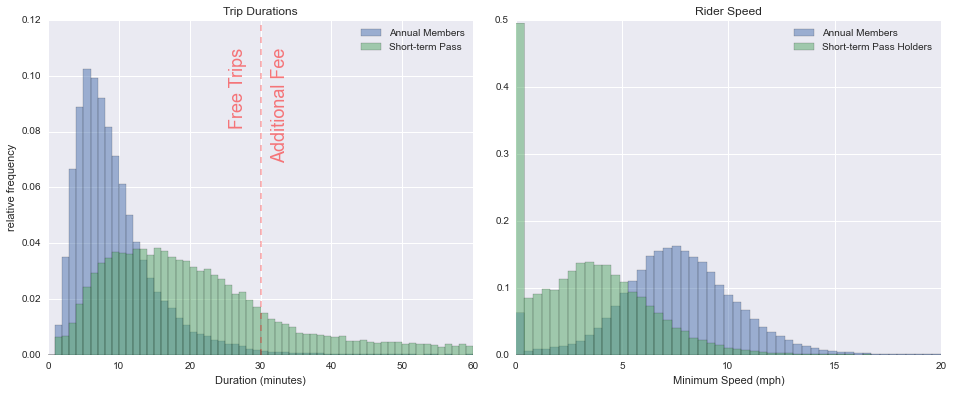

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.1)

trips['minutes'] = trips.tripduration / 60
trips.groupby('usertype')['minutes'].hist(bins=np.arange(61), alpha=0.5, normed=True, ax=ax[0]);
ax[0].set_xlabel('Duration (minutes)')
ax[0].set_ylabel('relative frequency')
ax[0].set_title('Trip Durations')
ax[0].text(34, 0.09, "Free Trips\n\nAdditional Fee", ha='right',
           size=18, rotation=90, alpha=0.5, color='red')
ax[0].legend(['Annual Members', 'Short-term Pass'])
ax[0].axvline(30, linestyle='--', color='red', alpha=0.3);

trips['minutes'] = trips['tripduration'] / 60
trips['speed'] = trips.distance * 60 / trips.minutes
trips.groupby('usertype')['speed'].hist(bins=np.linspace(0, 20, 50), normed=True,
                                        alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Minimum Speed (mph)')
ax[1].legend(['Annual Members', 'Short-term Pass Holders'])
ax[1].set_title('Rider Speed');

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


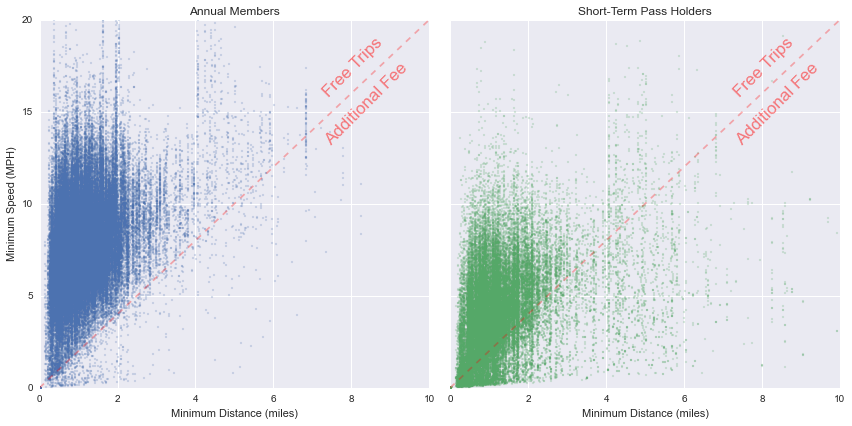

In [15]:
g = sns.FacetGrid(trips, col="usertype", hue='usertype', size=6)
g.map(plt.scatter, "distance", "speed", s=4, alpha=0.2)
g.axes[0, 0].axis([0, 10, 0, 25]);

for axi, col in zip(g.axes.flat, ['Annual Member', 'Short-Term Pass Holder']):
    axi.text(9.5, 16.6, "Free Trips\n\nAdditional Fee", ha='right',
             size=17, rotation=45, alpha=0.5, color='red')
    axi.plot([0, 20], [0, 40], '--r', alpha=0.3)
    axi.axis([0, 10, 0, 20])
    axi.set_title(col + 's')
    axi.set_xlabel('Minimum Distance (miles)')
g.axes[0, 0].set_ylabel('Minimum Speed (MPH)');

## Trend with Elevation

In [16]:
# Get elevations from the Google Maps API

def get_station_elevations(stations):
    """Get station elevations via Google Maps API"""
    URL = "https://maps.googleapis.com/maps/api/elevation/json?locations="
    locs = '|'.join(['{0},{1}'.format(lat, long)
                     for (lat, long) in zip(stations.lat, stations.long)])
    URL += locs
    !curl "{URL}" -o elevations.json


def process_station_elevations():
    """Convert Elevations JSON output to CSV"""
    import json
    D = json.load(open('elevations.json'))
    def unnest(D):
        loc = D.pop('location')
        loc.update(D)
        return loc
    elevs = pd.DataFrame([unnest(item) for item in D['results']])
    elevs.to_csv('station_elevations.csv')
    return elevs

# only run this the first time:
import os
if not os.path.exists('station_elevations.csv'):
    get_station_elevations(stations)
    process_station_elevations()

In [17]:
elevs = pd.read_csv('station_elevations.csv', index_col=0)
elevs.head()

,elevation,lat,lng,resolution
0,37.351780,47.618418,-122.350964,76.351616
1,33.815830,47.615829,-122.348564,76.351616
2,34.274055,47.616094,-122.341102,76.351616
3,44.283257,47.613110,-122.344208,76.351616
4,42.460381,47.610185,-122.339641,76.351616


In [18]:
# double check that locations match
print(np.allclose(stations.long, elevs.lng))
print(np.allclose(stations.lat, elevs.lat))

True
True


In [19]:
stations['elevation'] = elevs['elevation']
elevs.index = stations['terminal']

trips['elevation_start'] = trips.join(elevs, on='from_station_id')['elevation']
trips['elevation_end'] = trips.join(elevs, on='to_station_id')['elevation']
trips['elevation_gain'] = trips['elevation_end'] - trips['elevation_start']

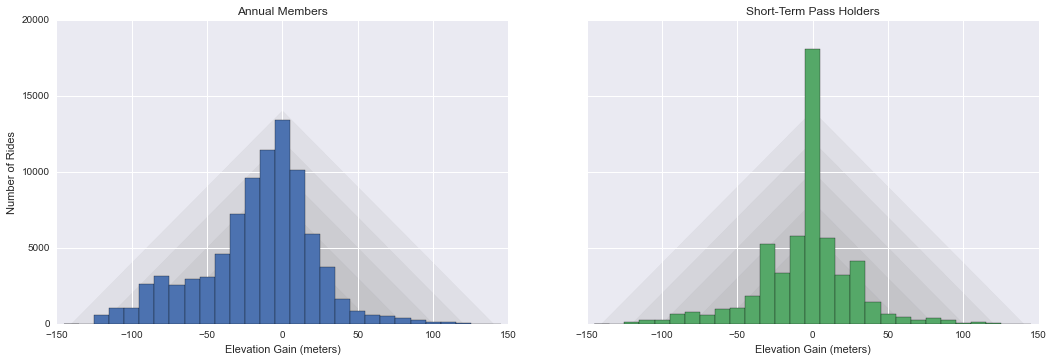

In [20]:
g = sns.FacetGrid(trips, col="usertype", hue='usertype')
g.map(plt.hist, "elevation_gain", bins=np.arange(-145, 150, 10))
g.fig.set_figheight(6)
g.fig.set_figwidth(16);

# plot some lines to guide the eye
for lim in range(60, 150, 20):
    x = np.linspace(-lim, lim, 3)
    for ax in g.axes.flat:
        ax.fill(x, 100 * (lim - abs(x)),
                color='gray', alpha=0.1, zorder=0)
        
g.axes[0, 0].set_title('Annual Members')
g.axes[0, 0].set_xlabel('Elevation Gain (meters)')
g.axes[0, 0].set_ylabel('Number of Rides')
g.axes[0, 1].set_title('Short-Term Pass Holders')
g.axes[0, 1].set_xlabel('Elevation Gain (meters)');

In [21]:
print("total downhill trips:", (trips.elevation_gain < 0).sum())
print("total uphill trips:  ", (trips.elevation_gain > 0).sum())

total downhill trips: 80532
total uphill trips:   50493


## Trend with Weather

In [22]:
weather = pd.read_csv('2015_weather_data.csv', index_col='Date', parse_dates=True)
weather.columns

Index(['Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF',
       'Max_Dew_Point_F', 'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity',
       'Mean_Humidity ', 'Min_Humidity ', 'Max_Sea_Level_Pressure_In ',
       'Mean_Sea_Level_Pressure_In ', 'Min_Sea_Level_Pressure_In ',
       'Max_Visibility_Miles ', 'Mean_Visibility_Miles ',
       'Min_Visibility_Miles ', 'Max_Wind_Speed_MPH ', 'Mean_Wind_Speed_MPH ',
       'Max_Gust_Speed_MPH', 'Precipitation_In ', 'Events'],
      dtype='object')

In [23]:
by_date = trips.groupby(['date', 'usertype'])['trip_id'].count()
by_date.name = 'count'
by_date = by_date.reset_index('usertype').join(weather)

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


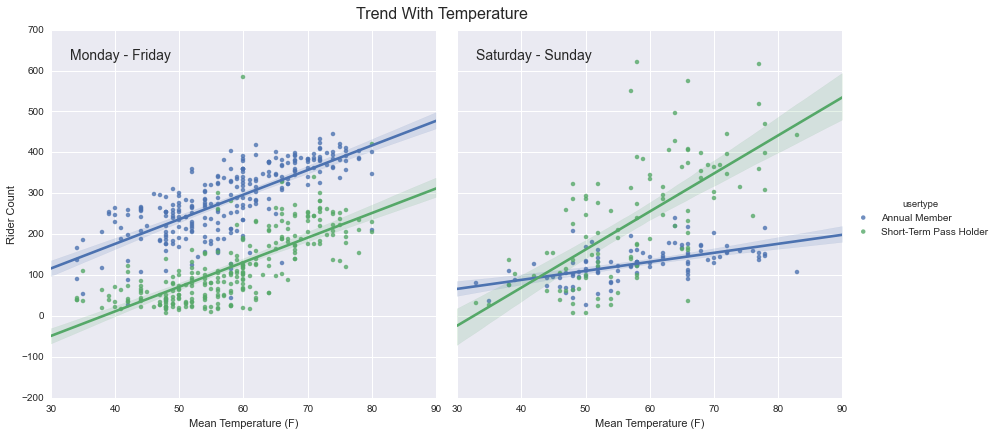

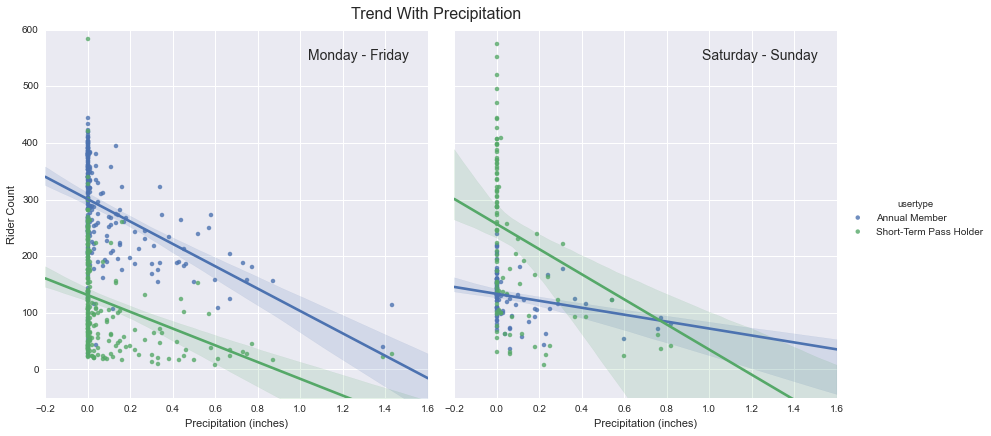

In [24]:
# add a flag indicating weekend
by_date['weekend'] = (by_date.index.dayofweek >= 5)

#----------------------------------------------------------------
# Plot Temperature Trend
g = sns.FacetGrid(by_date, col="weekend", hue='usertype', size=6)
g.map(sns.regplot, "Mean_Temperature_F", "count")
g.add_legend();

# do some formatting
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.05, 0.95, 'Monday - Friday', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.05, 0.95, 'Saturday - Sunday', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Trend With Temperature", ha='center', va='top', size=16);
for ax in g.axes.flat:
    ax.set_xlabel('Mean Temperature (F)')
g.axes.flat[0].set_ylabel('Rider Count')

#----------------------------------------------------------------
# Plot Precipitation
g = sns.FacetGrid(by_date, col="weekend", hue='usertype', size=6)
g.map(sns.regplot, "Precipitation_In ", "count")
g.add_legend();

# do some formatting
g.axes[0, 0].set_ylim(-50, 600);
g.axes[0, 0].set_title('')
g.axes[0, 1].set_title('')
g.axes[0, 0].text(0.95, 0.95, 'Monday - Friday', ha='right', va='top', size=14,
                  transform=g.axes[0, 0].transAxes)
g.axes[0, 1].text(0.95, 0.95, 'Saturday - Sunday', ha='right', va='top', size=14,
                  transform=g.axes[0, 1].transAxes)
g.fig.text(0.45, 1, "Trend With Precipitation", ha='center', va='top', size=16);
for ax in g.axes.flat:
    ax.set_xlabel('Precipitation (inches)')
g.axes.flat[0].set_ylabel('Rider Count');